In [1]:
!pip install optuna
import optuna

In [2]:
import gc
import os
import random
import csv
import sys
import json
import datetime

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from numba import jit
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 300)
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 300)

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm import tqdm

plt.style.use("seaborn")
sns.set(font_scale=1)

sample_submission = pd.read_csv("../input/data-science-bowl-2019/sample_submission.csv")
specs = pd.read_csv("../input/data-science-bowl-2019/specs.csv")
test = pd.read_csv("../input/data-science-bowl-2019/test.csv")
train = pd.read_csv("../input/data-science-bowl-2019/train.csv")
train_labels = pd.read_csv("../input/data-science-bowl-2019/train_labels.csv")
# test_labels = pd.read_csv("../input/dsb-each-attemption-result-in-test-data/results_in_test_agg.csv")

specs = specs.rename(columns={'info': 'information'})
specs["information"] = specs["information"].str[:40]
train["timestamp"] = pd.to_datetime(train['timestamp'])
test["timestamp"] = pd.to_datetime(test['timestamp'])

In [3]:
def prepare(df,test=False):
    keep_id = df[df.type == "Assessment"][['installation_id']].drop_duplicates()
    df = pd.merge(df, keep_id, on="installation_id", how="inner")
    attempt = df[((df.type=="Assessment") & (((df.event_code==4110) & (df.title=="Bird Measurer (Assessment)")) | ((df.event_code==4100) & (df.title!="Bird Measurer (Assessment)"))))]
    attempt.drop(["event_count", "event_code", "game_time"], axis=1, inplace=True)
    X = pd.DataFrame()
    for iid in tqdm(keep_id.installation_id):
        sample_id = attempt[attempt.installation_id == iid].reset_index()
        if(len(sample_id)==0):
            continue
        edata = pd.io.json.json_normalize(sample_id.event_data.apply(json.loads))
        sample_id = sample_id.join(edata)
        X = X.append(sample_id,ignore_index=True)
    X.drop(["event_data"],axis=1,inplace=True)
    X.drop(["index","buckets","buckets_placed","caterpillars","duration","left","pillars","right","stumps","timestamp"],axis=1,inplace=True)
    
#     le = LabelEncoder()
#     X.title = le.fit_transform(X.title)
#     X.type = le.fit_transform(X.type)
#     X.world = le.fit_transform(X.world)
    X.loc[X.correct==True,'target'] = 1
    X.loc[X.correct==False,'target'] = 0
    return X

def agg(df):
    df_agg = df.groupby(["installation_id","game_session"])["target"].agg({"num_collect":np.sum, "num_attempt":len})
    df_agg["accuracy"] = df_agg.num_collect/df_agg.num_attempt
    df_agg["accuracy_group"] = 0
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt==1),"accuracy_group"] = 3
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt==2),"accuracy_group"] = 2
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt>2),"accuracy_group"] = 1
    return df_agg

In [4]:
test_labels = prepare(test,True)
# print(test_labels)
test_labels = agg(test_labels)
test_labels = test_labels.reset_index()
# print(test_labels)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


100%|██████████| 1000/1000 [00:11<00:00, 85.39it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [5]:
keep_id = train_labels[['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = pd.merge(train,specs.loc[:,["event_id","information"]],on="event_id", how="left")
test = pd.merge(test,specs.loc[:,["event_id","information"]],on="event_id", how="left")

In [6]:
le_id = LabelEncoder()
le_id.fit_transform(pd.concat((train.installation_id,test.installation_id),axis=0).unique())
train.installation_id= le_id.transform(train.installation_id)
train_labels.installation_id= le_id.transform(train_labels.installation_id)
test.installation_id= le_id.transform(test.installation_id)
test_labels.installation_id= le_id.transform(test_labels.installation_id)
le = LabelEncoder()
le.fit_transform(pd.concat((train.game_session,test.game_session),axis=0).unique())
train.game_session= le.transform(train.game_session)
train_labels.game_session= le.transform(train_labels.game_session)
test.game_session= le.transform(test.game_session)
test_labels.game_session= le.transform(test_labels.game_session)
le_info = LabelEncoder()
le_info.fit_transform(specs.information)
train.information = le_info.transform(train.information)
test.information = le_info.transform(test.information)

In [7]:
# pd.set_option('line_width', 100)
df_info = pd.DataFrame({'info':le_info.classes_, 'code':le_info.transform(le_info.classes_)}).head(200)
# df_info.to_csv("info.csv",index=False)
#df_info

In [8]:
asslist = train_labels.title.unique()
infolist = range(df_info.code.max()+1)#[0,1,2,3,20,21,27,28,29,30,37,38,39]#[1,2,6,20,26,28,29,30,36,37]#
codelist = [3010,3020,4025,4030,4070]
typlist = ["Clip", "Game", "Activity", "Assessment"]
desc_in_infolist = ["GreatJob", "WhoaSoCool", "Amazing", "GoLower","Dot_Wow", "SoHigh", "NEXTSTONE", "NOT_THAT_HEAVY","RIGHTANSWER1","water_success"]
#print(asslist)

In [9]:
def features(X_df,df,stime):
    cnz = np.count_nonzero
    grp = df.groupby("game_session")
    typ = df.type
    evcode = df.event_code
    evcount1 = df.event_count == 1
    info = df.information
    X_df["sum_max_count"] = grp["event_count"].max().sum()
    X_df["mean_max_gametime"] = grp["game_time"].max().mean()
    X_df["sum_max_gametime"] = grp["game_time"].max().sum()
    X_df["mean_duration_gametime"] = grp["game_time"].max().sum()/len(df)
    X_df["unique_game_session"] = df.game_session.nunique()
    for i in typlist:
            X_df["count_{}".format(i)] = cnz((typ == i) & (evcount1))
    for i in codelist:
        X_df["count_{}".format(i)] = cnz(evcode == i)
    for i in infolist:
        X_df["count_info_{}".format(i)] = cnz(info == i)
    X_df["time_from_last_session"] = (stime - df.timestamp.max()).total_seconds()
    df_last = df[df.timestamp == df.timestamp.max()].copy()
    if len(df_last) == 0:
        X_df["last_session_title"] = "None"
    else:
        X_df["last_session_title"] = df_last.title.max()
    X_df["last_session_max_count"] = df_last["event_count"].max()
    X_df["last_session_max_gametime"] = df_last["game_time"].max()
    
    df_ass = df[(typ=="Assessment") & (((evcode==4110) & (df.title=="Bird Measurer (Assessment)")) | ((evcode==4100) & (df.title!="Bird Measurer (Assessment)")))].copy()
    X_df["count_correct"] = df_ass.event_data.str.contains('"correct":true').sum()
    X_df["count_incorrect"] = df_ass.event_data.str.contains('"correct":false').sum()
    if X_df.count_correct.max()+X_df.count_incorrect.max() == 0:
        X_df["rate_correct"] = -1
    else:
        X_df["rate_correct"] = X_df.count_correct.max()/(X_df.count_correct.max()+X_df.count_incorrect.max())
    for i in asslist:
        X_df["count_correct_{}".format(i)] = df_ass[df_ass.title == i].event_data.str.contains('"correct":true').sum()
        X_df["count_incorrect_{}".format(i)] = df_ass[df_ass.title == i].event_data.str.contains('"correct":false').sum()
        if X_df["count_correct_{}".format(i)].max()+X_df["count_incorrect_{}".format(i)].max() == 0:
            X_df["rate_correct_{}".format(i)] = -1
        else:
            X_df["rate_correct_{}".format(i)] = X_df["count_correct_{}".format(i)].max()/(X_df["count_correct_{}".format(i)].max()+X_df["count_incorrect_{}".format(i)].max())
    last_ass_gs = df_ass[df_ass.timestamp == df_ass.timestamp.max()].game_session.max()
    df_last_ass = df_ass[df_ass.game_session == last_ass_gs].copy()
    if len(df_last_ass) == 0:
        X_df["last_ass_title"] = "None"
    else:
        X_df["last_ass_title"] = df_last_ass.title.max()
    X_df["last_count_correct"] = df_last_ass.event_data.str.contains('"correct":true').sum()
    X_df["last_count_incorrect"] = df_last_ass.event_data.str.contains('"correct":false').sum()
    X_df["time_from_last_ass"] = (stime - df_last_ass.timestamp.max()).total_seconds()

#     for i in desc_in_infolist:
#         X_df["count_{}".format(i)] = df.event_data.str.contains(i).sum()
#     hour = stime.hour
#     X_df["hour_cos"] = np.cos(2 * np.pi * hour / 24)
#     X_df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
#    df_today = df[(df.timestamp.dt.month == stime.month) & (df.timestamp.dt.day == stime.day)].copy()
#    X_df["today_sum_max_count"] = df_today.groupby("game_session")["event_count"].max().sum()
#    X_df["today_mean_max_gametime"] = df_today.groupby("game_session")["game_time"].max().mean()
#    X_df["today_sum_max_gametime"] = df_today.groupby("game_session")["game_time"].max().sum()
#    X_df["today_duration_gametime"] = df_today.groupby("game_session")["game_time"].max().sum()/len(df_today)
#    X_df["today_unique_game_session"] = df_today.game_session.nunique()
#    for i in typlist:
#        X_df["today_count_{}".format(i)] = cnz((df_today.type == i) & (df_today.event_count == 1))

    return X_df

In [10]:
def make_dat(X_df,df):
    df_out = pd.DataFrame()
    ids = X_df.installation_id.unique()
    for id in tqdm(ids):
        df_id = df[df.installation_id == id]
        X_df_id = X_df[X_df.installation_id == id]
        sessions = X_df_id.game_session.unique()
        for gs in sessions:
            X_df_id_gs = X_df_id[X_df_id.game_session == gs]
            stime = df_id[df_id.game_session == gs].iloc[0].timestamp
            dfgs = features(X_df_id_gs.copy(),df_id[df_id.timestamp < stime].copy(),stime)
            df_out = df_out.append(dfgs)         
    return df_out

In [11]:
X_train = train_labels.merge(train[((train.type=="Assessment") &  (train.event_count==1))].loc[:,["game_session","installation_id","world"]],on=["installation_id","game_session"],how="left")
y_train = X_train.accuracy_group
X_train = make_dat(X_train, train)
print(X_train.columns)

  2%|▏         | 60/3614 [00:43<36:37,  1.62it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|██████████| 3614/3614 [49:27<00:00,  1.22it/s]


Index(['game_session', 'installation_id', 'title', 'num_correct',
       'num_incorrect', 'accuracy', 'accuracy_group', 'world', 'sum_max_count',
       'mean_max_gametime', 'sum_max_gametime', 'mean_duration_gametime',
       'unique_game_session', 'count_Clip', 'count_Game', 'count_Activity',
       'count_Assessment', 'count_3010', 'count_3020', 'count_4025',
       'count_4030', 'count_4070', 'count_info_0', 'count_info_1',
       'count_info_2', 'count_info_3', 'count_info_4', 'count_info_5',
       'count_info_6', 'count_info_7', 'count_info_8', 'count_info_9',
       'count_info_10', 'count_info_11', 'count_info_12', 'count_info_13',
       'count_info_14', 'count_info_15', 'count_info_16', 'count_info_17',
       'count_info_18', 'count_info_19', 'count_info_20', 'count_info_21',
       'count_info_22', 'count_info_23', 'count_info_24', 'count_info_25',
       'count_info_26', 'count_info_27', 'count_info_28', 'count_info_29',
       'count_info_30', 'count_info_31', 'count_inf

In [12]:
X_train.corr()

,game_session,installation_id,num_correct,num_incorrect,accuracy,accuracy_group,sum_max_count,mean_max_gametime,sum_max_gametime,mean_duration_gametime,unique_game_session,count_Clip,count_Game,count_Activity,count_Assessment,count_3010,count_3020,count_4025,count_4030,count_4070,count_info_0,count_info_1,count_info_2,count_info_3,count_info_4,count_info_5,count_info_6,count_info_7,count_info_8,count_info_9,count_info_10,count_info_11,count_info_12,count_info_13,count_info_14,count_info_15,count_info_16,count_info_17,count_info_18,count_info_19,count_info_20,count_info_21,count_info_22,count_info_23,count_info_24,count_info_25,count_info_26,count_info_27,count_info_28,count_info_29,count_info_30,count_info_31,count_info_32,count_info_33,count_info_34,count_info_35,count_info_36,count_info_37,count_info_38,count_info_39,time_from_last_session,last_session_max_count,last_session_max_gametime,count_correct,count_incorrect,rate_correct,count_correct_Mushroom Sorter (Assessment),count_incorrect_Mushroom Sorter (Assessment),rate_correct_Mushroom Sorter (Assessment),count_correct_Bird Measurer (Assessment),count_incorrect_Bird Measurer (Assessment),rate_correct_Bird Measurer (Assessment),count_correct_Cauldron Filler (Assessment),count_incorrect_Cauldron Filler (Assessment),rate_correct_Cauldron Filler (Assessment),count_correct_Chest Sorter (Assessment),count_incorrect_Chest Sorter (Assessment),rate_correct_Chest Sorter (Assessment),count_correct_Cart Balancer (Assessment),count_incorrect_Cart Balancer (Assessment),rate_correct_Cart Balancer (Assessment),last_count_correct,last_count_incorrect,time_from_last_ass
game_session,1.000000,-0.008519,0.011683,-0.014454,0.009325,0.009707,0.008728,-0.002588,0.005938,-0.003671,0.010125,0.011497,0.007808,0.009388,0.003506,0.010614,0.006441,0.013368,0.008452,0.003797,0.005139,0.007556,0.008130,0.006530,0.010565,0.003263,0.004873,0.007402,0.010901,0.008015,0.002081,0.007155,0.011930,0.000331,0.007873,0.007762,0.004722,0.000147,0.008204,0.002228,0.008250,0.006441,0.010614,0.011497,0.005322,0.013791,0.008909,0.007869,0.005869,0.008986,0.008759,0.012482,0.005426,0.003117,0.008219,0.005380,0.007279,0.006305,0.006688,0.013386,-0.005032,0.005228,0.005429,0.006067,0.004835,-0.001897,0.010111,-0.001815,0.003948,0.005677,0.007251,0.002330,0.005423,0.003889,-0.013446,0.003440,0.002643,0.002239,-0.003600,0.001896,-0.000079,0.001727,-0.000872,-0.001997
installation_id,-0.008519,1.000000,0.013905,0.008839,0.015049,0.013273,0.041786,0.003490,0.024129,-0.010299,-0.012225,-0.034522,0.049712,0.041371,-0.070225,0.053090,0.022906,0.015156,0.027293,0.029166,0.064708,0.067785,0.061244,0.024277,0.054063,0.105785,-0.008009,0.013090,0.088838,0.073109,-0.037812,0.045971,0.022385,0.007196,0.011837,0.015128,0.060754,-0.068391,0.066382,0.085275,0.060723,0.022906,0.053090,-0.034522,0.104943,0.031613,0.050267,0.011592,0.043150,0.022852,0.070279,0.005140,0.011286,-0.033710,0.049257,-0.061070,0.000899,-0.000119,0.053146,0.018040,0.010063,0.016642,-0.000282,-0.016249,-0.066290,-0.015145,-0.006171,-0.139058,-0.008621,-0.008999,0.030832,-0.041439,-0.061437,-0.094111,-0.010380,-0.017805,-0.011872,-0.010882,0.046791,-0.105157,0.007775,-0.000396,0.007849,0.014193
num_correct,0.011683,0.013905,1.000000,-0.417492,0.775654,0.840957,-0.050752,0.002083,-0.033714,-0.002760,-0.101309,-0.117819,-0.061600,-0.057913,-0.088452,-0.036761,-0.087828,-0.043469,-0.055301,-0.086424,-0.013753,-0.002889,0.000943,-0.085834,-0.035340,0.000842,0.017298,0.018241,0.005385,-0.009283,-0.040224,-0.025784,-0.066281,-0.012770,0.016062,-0.074364,-0.018931,-0.103418,-0.015825,-0.012178,0.000857,-0.087828,-0.036761,-0.117819,0.004872,0.019349,-0.032388,0.015900,-0.065691,-0.080919,-0.020946,0.003791,0.033731,-0.048553,0.003520,-0.107615,-0.062733,-0.052681,-0.002218,-0.024211,-0.003834,0.008709,-0.013813,0.013524,-0.130081,0.062204,-0.012365,-0.139226,0.092927,0.119276,-0.062018,0.074489,-0.044779,-0.147005,0.051291,0.083483,-0.025567,0.084227,0.020128,-0.119941,0

In [13]:
X_test = test[(test.type=="Assessment") & (test.event_count==1)].loc[:,["game_session","installation_id","title","world","timestamp"]].copy()
X_test = make_dat(X_test,test)
print(X_test.columns)

  4%|▎         | 35/1000 [00:18<13:45,  1.17it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|██████████| 1000/1000 [08:48<00:00,  1.89it/s]


Index(['game_session', 'installation_id', 'title', 'world', 'timestamp',
       'sum_max_count', 'mean_max_gametime', 'sum_max_gametime',
       'mean_duration_gametime', 'unique_game_session', 'count_Clip',
       'count_Game', 'count_Activity', 'count_Assessment', 'count_3010',
       'count_3020', 'count_4025', 'count_4030', 'count_4070', 'count_info_0',
       'count_info_1', 'count_info_2', 'count_info_3', 'count_info_4',
       'count_info_5', 'count_info_6', 'count_info_7', 'count_info_8',
       'count_info_9', 'count_info_10', 'count_info_11', 'count_info_12',
       'count_info_13', 'count_info_14', 'count_info_15', 'count_info_16',
       'count_info_17', 'count_info_18', 'count_info_19', 'count_info_20',
       'count_info_21', 'count_info_22', 'count_info_23', 'count_info_24',
       'count_info_25', 'count_info_26', 'count_info_27', 'count_info_28',
       'count_info_29', 'count_info_30', 'count_info_31', 'count_info_32',
       'count_info_33', 'count_info_34', 'count_i

In [14]:
X_train.head(100)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world,sum_max_count,mean_max_gametime,sum_max_gametime,mean_duration_gametime,unique_game_session,count_Clip,count_Game,count_Activity,count_Assessment,count_3010,count_3020,count_4025,count_4030,count_4070,count_info_0,count_info_1,count_info_2,count_info_3,count_info_4,count_info_5,count_info_6,count_info_7,count_info_8,count_info_9,count_info_10,count_info_11,count_info_12,count_info_13,count_info_14,count_info_15,count_info_16,count_info_17,count_info_18,count_info_19,count_info_20,count_info_21,count_info_22,count_info_23,count_info_24,count_info_25,count_info_26,count_info_27,count_info_28,count_info_29,count_info_30,count_info_31,count_info_32,count_info_33,count_info_34,count_info_35,count_info_36,count_info_37,count_info_38,count_info_39,time_from_last_session,last_session_title,last_session_max_count,last_session_max_gametime,count_correct,count_incorrect,rate_correct,count_correct_Mushroom Sorter (Assessment),count_incorrect_Mushroom Sorter (Assessment),rate_correct_Mushroom Sorter (Assessment),count_correct_Bird Measurer (Assessment),count_incorrect_Bird Measurer (Assessment),rate_correct_Bird Measurer (Assessment),count_correct_Cauldron Filler (Assessment),count_incorrect_Cauldron Filler (Assessment),rate_correct_Cauldron Filler (Assessment),count_correct_Chest Sorter (Assessment),count_incorrect_Chest Sorter (Assessment),rate_correct_Chest Sorter (Assessment),count_correct_Cart Balancer (Assessment),count_incorrect_Cart Balancer (Assessment),rate_correct_Cart Balancer (Assessment),last_ass_title,last_count_correct,last_count_incorrect,time_from_last_ass
0,86075,0,Mushroom Sorter (Assessment),1,0,1.000000,3,TREETOPCITY,1230,43688.923077,1135912,923.505691,26,14,6,4,2,228,22,59,171,160,6,21,16,22,225,1,1,0,2,2,1,4,4,0,0,12,6,1,27,1,16,22,228,14,2,0,23,0,248,68,19,0,0,0,0,12,124,84,0,18,58.105,Bird Measurer (Assessment),87.0,92799.0,1,11,0.083333,1,0,1.000000,0,11,0.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,Bird Measurer (Assessment),0,11,60.865
1,95597,0,Bird Measurer (Assessment),0,11,0.000000,0,TREETOPCITY,1143,41724.520000,1043113,912.609799,25,14,6,4,1,226,11,37,149,156,6,21,16,11,223,1,1,0,2,2,1,4,4,0,0,11,6,1,26,1,16,11,226,14,2,0,23,0,244,46,19,0,0,0,0,1,102,84,0,18,14.566,Bug Measurer (Activity),204.0,104816.0,1,0,1.000000,1,0,1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,Mushroom Sorter (Assessment),1,0,766.810
2,114978,0,Mushroom Sorter (Assessment),1,0,1.000000,3,TREETOPCITY,647,34806.500000,626517,968.341577,18,11,4,3,0,79,7,19,121,94,6,18,9,7,77,0,0,0,0,2,1,4,4,0,0,7,6,0,20,0,9,7,79,11,0,0,23,0,147,24,19,0,0,0,0,0,71,78,0,18,57.120,Pirate's Tale,1.0,0.0,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,None,0,0,NaN
3,118906,0,Mushroom Sorter (Assessment),1,1,0.500000,2,TREETOPCITY,2159,73536.829787,3456231,1600.848078,47,24,10,9,4,341,25,93,314,348,9,45,40,25,336,1,2,2,2,5,2,8,4,0,2,23,10,3,53,1,40,25,341,24,2,5,70,2,500,110,38,22,0,0,6,13,206,124,21,37,9.697,Mushroom Sorter (Assessment),17.0,8789.0,2,11,0.153846,2,0,1.000000,0,11,0.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,Mushroom Sorter (Assessment),1,0,53805.776
4,135589,0,Bird Measurer (Assessment),1,0,1.000000,3,TREETOPCITY,2586,70448.125000,3945095,1525.558778,56,28,13,10,5,463,30,105,331,387,9,49,53,30,457,1,3,2,9,5,2,8,4,1,2,28,10,4,65,2,53,30,463,28,2,5,70,2,573,121,38,22,0,0,6,15,226,130,21,37,11.063,Bug Measurer (Activity),115.0,80899.0,3,12,0.200000,3,1,0.750000,0,11,0.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,Mushroom Sorter (Assessment),1,1,882.249
5,20353,1,Cauldron Filler (Assessment),1,0,1.000000,3,MAGMAPEAK,1542,53140.960000,1328524,861.559014,25,15,4,6,0,199,23,8,192,482,5,43,15,23,197,1,0,1,0,3,1,4,0,0,1,10,6,0,46,1,16,23,199,15,0,0,0,1,556,38,0,0,6,0,0,0,179,106,46,0,50.158,Magma Peak - Level 2,1.0,0.0,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.000000,0,0,-1.0,None,0,0,NaN
6,119

In [15]:
le = LabelEncoder()
X_train.title= le.fit_transform(X_train.title)
X_test.title= le.transform(X_test.title)
le = LabelEncoder()
le.fit_transform(pd.concat((train.title,X_train.last_session_title),axis=0).unique())
X_train.last_session_title= le.transform(X_train.last_session_title)
X_test.last_session_title= le.transform(X_test.last_session_title)
le = LabelEncoder()
le.fit_transform(pd.concat((train_labels.title,X_train.last_ass_title),axis=0).unique())
X_train.last_ass_title= le.transform(X_train.last_ass_title)
X_test.last_ass_title= le.transform(X_test.last_ass_title)
le = LabelEncoder()
X_train.world= le.fit_transform(X_train.world)
X_test.world= le.transform(X_test.world)


In [16]:
X_train.drop(["installation_id","game_session"],axis=1,inplace=True)
X_te = X_test.copy()
X_te.drop(["installation_id","game_session","timestamp"],axis=1,inplace=True)

In [17]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def linear_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = abs(i - j) / float(num_ratings - 1)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            if i == j:
                d = 0.0
            else:
                d = 1.0
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def weighted_mean_quadratic_weighted_kappa(solution, submission):
    predicted_score = submission[submission.columns[-1]].copy()
    predicted_score.name = "predicted_score"
    if predicted_score.index[0] == 0:
        predicted_score = predicted_score[:len(solution)]
        predicted_score.index = solution.index
    combined = solution.join(predicted_score, how="left")
    groups = combined.groupby(by="essay_set")
    kappas = [quadratic_weighted_kappa(group[1]["essay_score"], group[1]["predicted_score"]) for group in groups]
    weights = [group[1]["essay_weight"].irow(0) for group in groups]
    return mean_quadratic_weighted_kappa(kappas, weights=weights)

In [18]:
X_train_origin = X_train.copy()
y_train_origin = y_train.copy()
train_labels_origin = train_labels.copy()
categorical_features = ["title","world","last_session_title","last_ass_title"]

In [19]:
def objective(trial):
    nsplits = 5
    nrand = 10

    df_fimp = pd.DataFrame()
    init = True

    for rand in range(nrand):
#         random.seed(rand)
        indexes = X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=rand).index)
        X_train = X_train_origin[~indexes].copy()
        y_train = y_train_origin[~indexes].copy()
        train_labels = train_labels_origin[~indexes].copy()
        X_train.drop(["num_correct","num_incorrect","accuracy","accuracy_group"],axis=1,inplace=True)

        folds = KFold(n_splits=nsplits, shuffle=True, random_state=rand)
        params = {
        "objective": "regression",
        "boosting": "dart",
        "drop_rate": trial.suggest_uniform('drop_rate', 0.01, 0.1),
        "max_drop": trial.suggest_int('max_drop', 3, 20),
        "drop_seed": rand,
        "max_depth": trial.suggest_int('max_depth', 4, 40),
        "num_leaves": trial.suggest_int('num_leaves', 4, 50),
        "subsample": trial.suggest_uniform('subsample', 0.5, 1.0),
        "subsample_freq": 1,
        "bagging_seed": rand+10,
        "learning_rate": trial.suggest_uniform('learning_rate', 0.01, 0.15),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        "feature_seed": rand+100,
        "lambda_l1": 2,
        "lambda_l2": 2,
        "random_state": rand+1000,
        "metric": "rmse"
        }
        pred = np.zeros(len(X_te))
        tpred = np.zeros(len(X_train))
        for tr_idx,va_idx in folds.split(X_train,y_train):
            X_half_1 = X_train.iloc[tr_idx]
            y_half_1 = y_train.iloc[tr_idx]
            X_half_2 = X_train.iloc[va_idx]
            y_half_2 = y_train.iloc[va_idx]

            d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
            d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

            model_half = lgb.train(params, train_set=d_half_1, num_boost_round=3000, valid_sets=[d_half_1,d_half_2], verbose_eval=3000, early_stopping_rounds=50)

            tpred += model_half.predict(X_train, num_iteration=model_half.best_iteration) / nsplits
            pred += model_half.predict(X_te, num_iteration=model_half.best_iteration) / nsplits

            df_fimp_1 = pd.DataFrame()
            df_fimp_1["feature"] = X_train.columns.values
            df_fimp_1["importance"] = model_half.feature_importance()

            df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
            del model_half
            gc.collect()

        if init:
            pred_total = pred
            tpred_total = tpred
            tlabel = train_labels.accuracy_group
            init = False
        else:
            #         pred_total = np.concatenate([pred_total,pred])
            pred_total += pred
            tpred_total = np.concatenate([tpred_total,tpred])
            #         tpred_total += tpred
            tlabel = np.concatenate([tlabel,train_labels.accuracy_group])
    pred_total /= nrand

    X_train = X_train_origin[~X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=0).index)].copy()
    psort = tpred_total.copy()
    psort.sort()
    th1 = psort[int(np.count_nonzero(X_train.accuracy_group<1)/len(X_train)*len(psort))]
    th2 = psort[int(np.count_nonzero(X_train.accuracy_group<2)/len(X_train)*len(psort))]
    th3 = psort[int(np.count_nonzero(X_train.accuracy_group<3)/len(X_train)*len(psort))]

    X_te_agg = X_test.copy()
    X_te_agg["accuracy_group"] = 0
    X_te_agg.loc[pred_total > th1,"accuracy_group"] = 1
    X_te_agg.loc[pred_total > th2,"accuracy_group"] = 2
    X_te_agg.loc[pred_total > th3,"accuracy_group"] = 3
    X_te_agg = X_te_agg.merge(test_labels.loc[:,["installation_id","game_session","accuracy_group"]],on=["installation_id","game_session"],how="left")
    eval = X_te_agg[~X_te_agg.accuracy_group_y.isna()]
    return -1 * quadratic_weighted_kappa(eval.reset_index().accuracy_group_x.astype("int"),eval.reset_index().accuracy_group_y.astype("int"))

In [20]:
study = optuna.create_study(study_name="dsb2019")
study.optimize(objective, n_trials=8,n_jobs=-1)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/callback.py:188: UserWarning:

Early stopping is not available in dart mode



[3000]	training's rmse: 0.92452	valid_1's rmse: 0.993977
[3000]	training's rmse: 0.923212	valid_1's rmse: 1.00189
[3000]	training's rmse: 0.720994	valid_1's rmse: 0.986673
[3000]	training's rmse: 0.51693	valid_1's rmse: 1.59742
[3000]	training's rmse: 0.331899	valid_1's rmse: 1.04169
[3000]	training's rmse: 0.92441	valid_1's rmse: 0.992413
[3000]	training's rmse: 0.921808	valid_1's rmse: 1.00092
[3000]	training's rmse: 0.718553	valid_1's rmse: 0.999652
[3000]	training's rmse: 0.46756	valid_1's rmse: 1.83237
[3000]	training's rmse: 0.33643	valid_1's rmse: 1.02997
[3000]	training's rmse: 0.926345	valid_1's rmse: 0.983308
[3000]	training's rmse: 0.93399	valid_1's rmse: 0.979583
[3000]	training's rmse: 0.717371	valid_1's rmse: 0.989902
[3000]	training's rmse: 0.525533	valid_1's rmse: 2.07643
[3000]	training's rmse: 0.930988	valid_1's rmse: 0.988972
[3000]	training's rmse: 0.336136	valid_1's rmse: 1.02816
[3000]	training's rmse: 0.92229	valid_1's rmse: 1.02267
[3000]	training's rmse: 0.7158

[I 2020-01-11 00:49:56,747] Finished trial#3 resulted in value: -0.5534272257639296. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.32874	valid_1's rmse: 1.05168
[3000]	training's rmse: 0.726682	valid_1's rmse: 0.976216
[3000]	training's rmse: 0.462902	valid_1's rmse: 1.00999
[3000]	training's rmse: 0.254326	valid_1's rmse: 1.03611
[3000]	training's rmse: 0.327113	valid_1's rmse: 1.01466
[3000]	training's rmse: 0.719406	valid_1's rmse: 1.00461
[3000]	training's rmse: 0.665408	valid_1's rmse: 1.50411
[3000]	training's rmse: 0.326093	valid_1's rmse: 1.0068
[3000]	training's rmse: 0.251092	valid_1's rmse: 1.06605
[3000]	training's rmse: 0.722416	valid_1's rmse: 0.986288
[3000]	training's rmse: 0.479223	valid_1's rmse: 1.54267
[3000]	training's rmse: 0.71946	valid_1's rmse: 0.997135
[3000]	training's rmse: 0.337864	valid_1's rmse: 1.01675
[3000]	training's rmse: 0.247793	valid_1's rmse: 1.04486
[3000]	training's rmse: 0.506835	valid_1's rmse: 1.62476
[3000]	training's rmse: 0.721489	valid_1's rmse: 0.987613
[3000]	training's rmse: 0.347551	valid_1's rmse: 1.05642
[3000]	training's rmse: 0.2500

[I 2020-01-11 01:56:24,511] Finished trial#1 resulted in value: -0.5504346696055318. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.461169	valid_1's rmse: 1.042
[3000]	training's rmse: 0.323112	valid_1's rmse: 1.01904
[3000]	training's rmse: 0.242167	valid_1's rmse: 1.05081
[3000]	training's rmse: 0.479155	valid_1's rmse: 1.05676
[3000]	training's rmse: 0.283878	valid_1's rmse: 1.01016
[3000]	training's rmse: 0.377516	valid_1's rmse: 1.42163
[3000]	training's rmse: 0.517147	valid_1's rmse: 1.77357
[3000]	training's rmse: 0.249916	valid_1's rmse: 1.42951
[3000]	training's rmse: 0.282445	valid_1's rmse: 1.0326
[3000]	training's rmse: 0.551058	valid_1's rmse: 1.24564
[3000]	training's rmse: 0.568606	valid_1's rmse: 1.82696
[3000]	training's rmse: 0.243144	valid_1's rmse: 1.04608
[3000]	training's rmse: 0.27932	valid_1's rmse: 1.01871
[3000]	training's rmse: 0.338308	valid_1's rmse: 1.33568
[3000]	training's rmse: 0.464115	valid_1's rmse: 1.53611


[I 2020-01-11 02:07:42,115] Finished trial#2 resulted in value: -0.5438743695342455. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.242104	valid_1's rmse: 1.05459
[3000]	training's rmse: 0.351048	valid_1's rmse: 1.13935
[3000]	training's rmse: 0.362855	valid_1's rmse: 1.03323
[3000]	training's rmse: 0.28147	valid_1's rmse: 1.03014
[3000]	training's rmse: 0.357726	valid_1's rmse: 1.05723
[3000]	training's rmse: 0.242633	valid_1's rmse: 1.0254
[3000]	training's rmse: 0.401963	valid_1's rmse: 1.32647


[I 2020-01-11 02:12:45,585] Finished trial#0 resulted in value: -0.5457242681807053. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.28102	valid_1's rmse: 1.01354
[3000]	training's rmse: 0.3569	valid_1's rmse: 1.03993
[3000]	training's rmse: 0.715544	valid_1's rmse: 0.986444
[3000]	training's rmse: 0.240693	valid_1's rmse: 1.06297
[3000]	training's rmse: 0.281886	valid_1's rmse: 1.00602
[3000]	training's rmse: 0.355776	valid_1's rmse: 1.06054
[3000]	training's rmse: 0.714288	valid_1's rmse: 0.999762
[3000]	training's rmse: 0.245743	valid_1's rmse: 1.03917
[3000]	training's rmse: 0.357173	valid_1's rmse: 1.03003
[3000]	training's rmse: 0.284755	valid_1's rmse: 1.02216
[3000]	training's rmse: 0.712702	valid_1's rmse: 0.990542
[3000]	training's rmse: 0.366535	valid_1's rmse: 1.03332
[3000]	training's rmse: 0.251253	valid_1's rmse: 1.05603
[3000]	training's rmse: 0.283577	valid_1's rmse: 1.03754
[3000]	training's rmse: 0.370487	valid_1's rmse: 1.0414
[3000]	training's rmse: 0.711013	valid_1's rmse: 0.999563
[3000]	training's rmse: 0.243016	valid_1's rmse: 1.04533
[3000]	training's rmse: 0.36874

[I 2020-01-11 03:34:46,581] Finished trial#4 resulted in value: -0.5104757479548518. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.284052	valid_1's rmse: 1.01203
[3000]	training's rmse: 0.355436	valid_1's rmse: 1.03932
[3000]	training's rmse: 0.697761	valid_1's rmse: 0.996973
[3000]	training's rmse: 0.353809	valid_1's rmse: 1.04107
[3000]	training's rmse: 0.699365	valid_1's rmse: 0.988739
[3000]	training's rmse: 0.285876	valid_1's rmse: 1.02663
[3000]	training's rmse: 0.350262	valid_1's rmse: 1.06223
[3000]	training's rmse: 0.699807	valid_1's rmse: 0.995816
[3000]	training's rmse: 0.281864	valid_1's rmse: 1.04115
[3000]	training's rmse: 0.349815	valid_1's rmse: 1.0348
[3000]	training's rmse: 0.717021	valid_1's rmse: 1.0074
[3000]	training's rmse: 0.352699	valid_1's rmse: 1.04656
[3000]	training's rmse: 0.284155	valid_1's rmse: 1.01896
[3000]	training's rmse: 0.348624	valid_1's rmse: 1.04739
[3000]	training's rmse: 0.720045	valid_1's rmse: 0.997779
[3000]	training's rmse: 0.285448	valid_1's rmse: 1.02475
[3000]	training's rmse: 0.347093	valid_1's rmse: 1.03752
[3000]	training's rmse: 0.718

[I 2020-01-11 04:01:01,334] Finished trial#6 resulted in value: -0.525633512846279. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.297776	valid_1's rmse: 1.02161
[3000]	training's rmse: 0.713999	valid_1's rmse: 1.00552
[3000]	training's rmse: 0.296208	valid_1's rmse: 1.03403
[3000]	training's rmse: 0.714356	valid_1's rmse: 0.985017
[3000]	training's rmse: 0.293991	valid_1's rmse: 1.01226
[3000]	training's rmse: 0.707109	valid_1's rmse: 0.999302
[3000]	training's rmse: 0.706689	valid_1's rmse: 0.995981
[3000]	training's rmse: 0.291185	valid_1's rmse: 1.02476
[3000]	training's rmse: 0.708021	valid_1's rmse: 0.991301
[3000]	training's rmse: 0.287406	valid_1's rmse: 1.02591
[3000]	training's rmse: 0.708024	valid_1's rmse: 0.996201
[3000]	training's rmse: 0.2857	valid_1's rmse: 1.02242
[3000]	training's rmse: 0.706532	valid_1's rmse: 0.999921
[3000]	training's rmse: 0.713916	valid_1's rmse: 1.01834
[3000]	training's rmse: 0.288433	valid_1's rmse: 1.02843
[3000]	training's rmse: 0.714947	valid_1's rmse: 1.00697
[3000]	training's rmse: 0.288148	valid_1's rmse: 1.02311
[3000]	training's rmse: 0.7

[I 2020-01-11 04:22:13,531] Finished trial#7 resulted in value: -0.5494551334123481. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


[3000]	training's rmse: 0.283762	valid_1's rmse: 1.0056
[3000]	training's rmse: 0.287877	valid_1's rmse: 1.01242
[3000]	training's rmse: 0.282747	valid_1's rmse: 1.03351


[I 2020-01-11 04:25:54,796] Finished trial#5 resulted in value: -0.5247894695694442. Current best value is -0.5534272257639296 with parameters: {'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}.


In [21]:
print(study.best_value)
print(study.best_params)

-0.5534272257639296
{'drop_rate': 0.04206504005070515, 'max_drop': 17, 'max_depth': 21, 'num_leaves': 5, 'subsample': 0.7462877695023188, 'learning_rate': 0.03516834382413876, 'feature_fraction': 0.5057805440533957}


In [22]:
nsplits = 5
nrand = 10

df_fimp = pd.DataFrame()
init = True

for rand in range(nrand):
    #random.seed(rand)
    indexes = X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=rand).index)
    X_train = X_train_origin[~indexes].copy()
    y_train = y_train_origin[~indexes].copy()
    train_labels = train_labels_origin[~indexes].copy()
    X_train.drop(["num_correct","num_incorrect","accuracy","accuracy_group"],axis=1,inplace=True)

    folds = KFold(n_splits=nsplits, shuffle=True, random_state=rand)
    params = {
    "objective": "regression",
    "boosting": "dart",
    "drop_rate": study.best_params['drop_rate'],
    "max_drop": study.best_params['max_drop'],
    "drop_seed": rand,
    "max_depth": study.best_params['max_depth'],
    "num_leaves": study.best_params['num_leaves'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": 1,
    "bagging_seed": rand+10,
    "learning_rate": study.best_params['learning_rate'],
    "feature_fraction": study.best_params['feature_fraction'],
    "feature_seed": rand+100,
    "lambda_l1": 2,
    "lambda_l2": 2,
    "random_state": rand+1000,
    "metric": "rmse"
    }
    pred = np.zeros(len(X_te))
    tpred = np.zeros(len(X_train))
    for tr_idx,va_idx in folds.split(X_train,y_train):
        X_half_1 = X_train.iloc[tr_idx]
        y_half_1 = y_train.iloc[tr_idx]
        X_half_2 = X_train.iloc[va_idx]
        y_half_2 = y_train.iloc[va_idx]

        d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
        d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

        model_half = lgb.train(params, train_set=d_half_1, num_boost_round=3000, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)

        tpred += model_half.predict(X_train, num_iteration=model_half.best_iteration) / nsplits
        pred += model_half.predict(X_te, num_iteration=model_half.best_iteration) / nsplits

        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = X_train.columns.values
        df_fimp_1["importance"] = model_half.feature_importance()

        df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
        del model_half
        gc.collect()

    if init:
        pred_total = pred
        tpred_total = tpred
        tlabel = train_labels.accuracy_group
        init = False
    else:
#         pred_total = np.concatenate([pred_total,pred])
        pred_total += pred
        tpred_total = np.concatenate([tpred_total,tpred])
#         tpred_total += tpred
        tlabel = np.concatenate([tlabel,train_labels.accuracy_group])
pred_total /= nrand

[100]	training's rmse: 1.14993	valid_1's rmse: 1.14694
[200]	training's rmse: 1.06356	valid_1's rmse: 1.06764
[300]	training's rmse: 1.03641	valid_1's rmse: 1.0439
[400]	training's rmse: 1.02002	valid_1's rmse: 1.03095
[500]	training's rmse: 1.01273	valid_1's rmse: 1.02558
[600]	training's rmse: 1.00399	valid_1's rmse: 1.01918
[700]	training's rmse: 1.00163	valid_1's rmse: 1.01761
[800]	training's rmse: 0.992706	valid_1's rmse: 1.01181
[900]	training's rmse: 0.986345	valid_1's rmse: 1.00857
[1000]	training's rmse: 0.979043	valid_1's rmse: 1.00496
[1100]	training's rmse: 0.975772	valid_1's rmse: 1.00476
[1200]	training's rmse: 0.971899	valid_1's rmse: 1.00332
[1300]	training's rmse: 0.968006	valid_1's rmse: 1.00137
[1400]	training's rmse: 0.96372	valid_1's rmse: 0.999849
[1500]	training's rmse: 0.961216	valid_1's rmse: 0.999482
[1600]	training's rmse: 0.96074	valid_1's rmse: 1.00008
[1700]	training's rmse: 0.956691	valid_1's rmse: 0.99816
[1800]	training's rmse: 0.954673	valid_1's rmse:

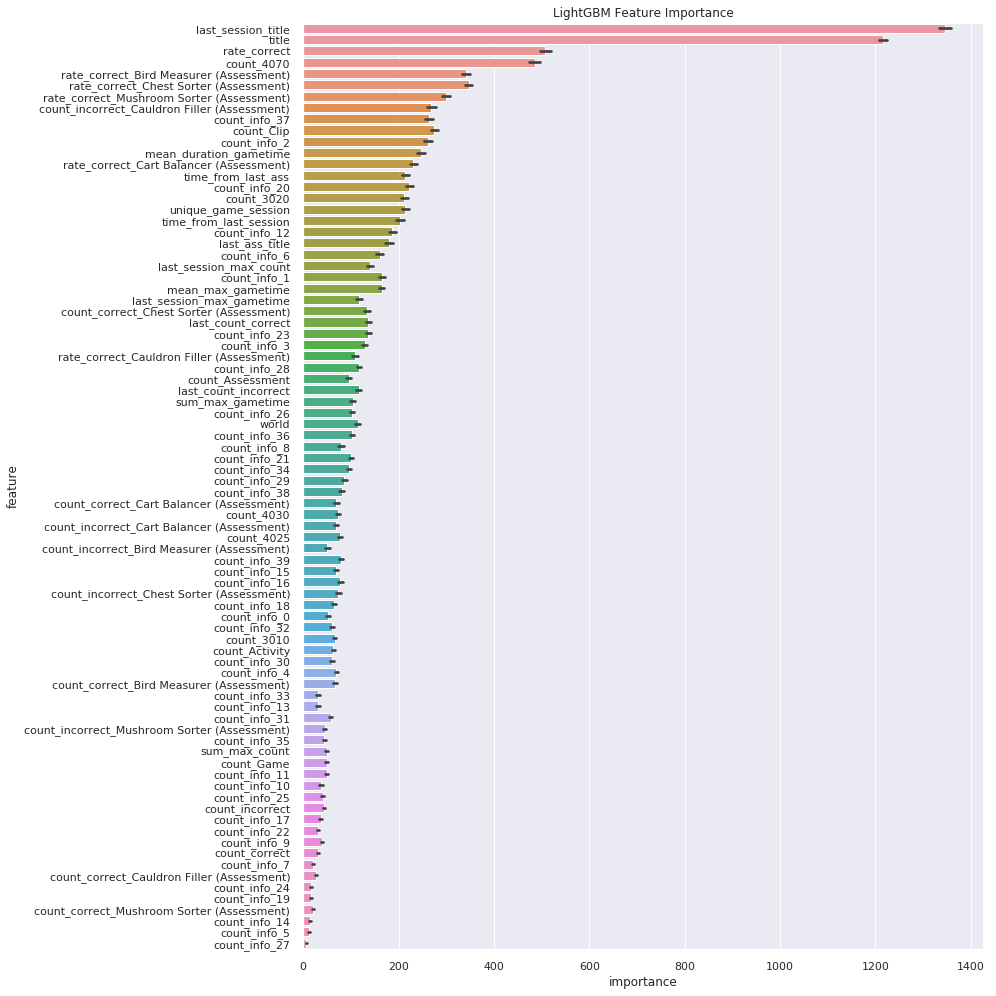

In [23]:
plt.figure(figsize=(14, 14))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

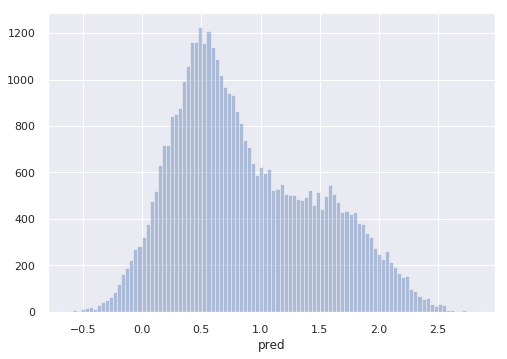

In [24]:
# print(len(train_labels))
# print(len(tpred))
p = pd.DataFrame({"lab":tlabel, "pred":tpred_total,"pclass": np.trunc(tpred_total*100)})
sns.distplot(p[p.lab==0].pred, kde=False, rug=False, bins=100) 

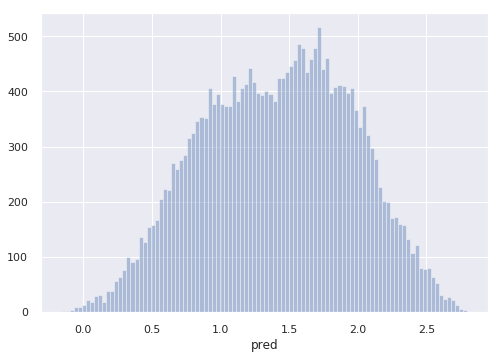

In [25]:
sns.distplot(p[p.lab==1].pred, kde=False, rug=False, bins=100) 

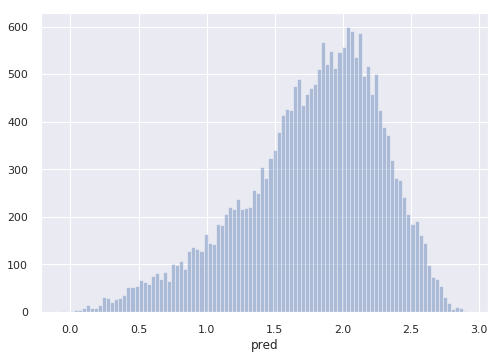

In [26]:
sns.distplot(p[p.lab==2].pred, kde=False, rug=False, bins=100) 

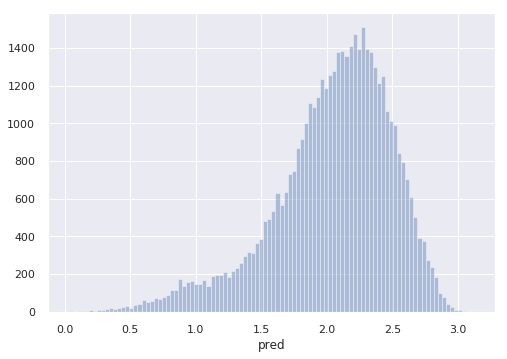

In [27]:
sns.distplot(p[p.lab==3].pred, kde=False, rug=False, bins=100) 

In [28]:
X_train = X_train_origin[~X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=0).index)].copy()
psort = tpred_total.copy()
psort.sort()
th1 = psort[int(np.count_nonzero(X_train.accuracy_group<1)/len(X_train)*len(psort))]
th2 = psort[int(np.count_nonzero(X_train.accuracy_group<2)/len(X_train)*len(psort))]
th3 = psort[int(np.count_nonzero(X_train.accuracy_group<3)/len(X_train)*len(psort))]
print(th1,th2,th3)

1.1456422064047689 1.6320586583531331 1.9413058050836898


In [29]:
best_th1 = th1
best_th2 = th2
best_th3 = th3
best_cappa = 0
for t1 in tqdm(np.arange(th1-0.1,th1+0.1,0.01)):
    for t2 in np.arange(th2-0.1,th2+0.1,0.01):
        for t3 in np.arange(th3-0.1,th3+0.1,0.01):
            X_te_agg = X_test.copy()
            X_te_agg["accuracy_group"] = 0
            X_te_agg.loc[pred_total > t1,"accuracy_group"] = 1
            X_te_agg.loc[pred_total > t2,"accuracy_group"] = 2
            X_te_agg.loc[pred_total > t3,"accuracy_group"] = 3
            X_te_agg = X_te_agg.merge(test_labels.loc[:,["installation_id","game_session","accuracy_group"]],on=["installation_id","game_session"],how="left")
            eval = X_te_agg[~X_te_agg.accuracy_group_y.isna()]
            ca = quadratic_weighted_kappa(eval.reset_index().accuracy_group_x.astype("int"),eval.reset_index().accuracy_group_y.astype("int"))
            if ca > best_cappa:
                best_cappa = ca
                best_th1 = t1
                best_th2 = t2
                best_th3 = t3
print(best_cappa,best_th1,best_th2,best_th3)

X_te_agg = X_test.copy()
X_te_agg["accuracy_group"] = 0
X_te_agg.loc[pred_total > best_th1,"accuracy_group"] = 1
X_te_agg.loc[pred_total > best_th2,"accuracy_group"] = 2
X_te_agg.loc[pred_total > best_th3,"accuracy_group"] = 3
X_te_agg = X_te_agg.merge(test_labels.loc[:,["installation_id","game_session","accuracy_group"]],on=["installation_id","game_session"],how="left")
X_te_agg["accuracy_group"] = np.where(X_te_agg.accuracy_group_y.isna(),X_te_agg.accuracy_group_x,X_te_agg.accuracy_group_y)
X_te_agg.drop(["accuracy_group_x","accuracy_group_y"],axis=1,inplace=True)
# X_te_agg = X_te_agg.merge(test.loc[(test.type=="Assessment") & (test.event_count==1),["installation_id","game_session","timestamp"]],on=["installation_id","game_session"],how="left")
#print(X_te_agg.head(20))

100%|██████████| 21/21 [06:38<00:00, 19.00s/it]


0.5681799856429857 1.155642206404769 1.532058658353133 1.8613058050836897


In [30]:
X_te_ans = X_te_agg.iloc[X_te_agg.groupby("installation_id")["timestamp"].idxmax()][["installation_id","accuracy_group"]].astype({"accuracy_group": int}).reset_index()[["installation_id","accuracy_group"]]
# X_te_ans = X_te_agg.groupby("installation_id")["accuracy_group"].last().astype({"accuracy_group": int}).reset_index()
X_te_ans.installation_id = le_id.inverse_transform(X_te_ans.installation_id)
X_te_ans.to_csv("submission.csv",index=False)
print(len(X_te_ans))
print(X_te_ans.head(10))

1000
  installation_id  accuracy_group
0        00abaee7               3
1        01242218               3
2        017c5718               3
3        01a44906               3
4        01bc6cb6               3
5        02256298               3
6        0267757a               2
7        027e7ce5               3
8        02a29f99               0
9        0300c576               0


In [31]:
for i in range(4):
    print(len(X_te_ans[X_te_ans.accuracy_group==i]))

216
123
193
468
